In [1]:
# -*- coding: utf-8 -*-

from gensim import corpora, matutils
import pandas as pd
import MeCab
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer


def readCSV(file_pass, name, file_type):
    df = pd.read_csv(file_pass+name+file_type, dtype={'label': 'str'}, encoding="utf-8")
    return df


def sep(body):
    mt = MeCab.Tagger('mecabrc')
    mt.parse("")
    node = mt.parseToNode(str(body))
    return getNouns(node)


def getNouns(node):
    words = []
    word_stack = ""
    while node:
        noun = node.feature.split(",")
        word = node.surface
        if(checkNoun(noun)):
            word_stack += word
        if(word_stack != "" and noun[0] != '名詞'):
            if(checkNum(word_stack)):
                words.append(word_stack)
            word_stack = ""
        node = node.next
#     words = " ".join(words)
    return words


# 名詞のみを抽出
def checkNoun(noun):
    if(noun[0] == '名詞'):
        if(noun[1] != '副詞可能'):
            if(noun[1] != '非自立'):
                if(noun[1] != '代名詞'):
                    if(noun[1] != '助詞類接続'):
                        return True
                    else:
                        return False
                else:
                    return False
            else:
                return False
        else:
            return False
    else:
        return False


# 12月 1.2%などの数字関連を省く
def checkNum(word_stack):
    mt = MeCab.Tagger()
    mt.parse("")

    node = mt.parseToNode(word_stack)
    while node:
        noun = node.feature.split(",")
        if(noun[1] == '数'):
            return False
        node = node.next

    return True

#ラベル付け
def ch(cat_list):
    cats = []
    for cat, i in zip(cat_list, range(len(cat_list))):
        if(cat == "1"):
            cats.append(i)
    if(cats == []):
        #すべての要素が0の時にその他のラベルである13をあてる
        cats.append(13)
    return np.asarray(cats)


Using TensorFlow backend.


In [2]:
file_pass = "./"
#3が自作関数での分割
file_name = "reuters_article"
file_type = ".csv"
dict_list = []
# print(dict_list)
df = readCSV(file_pass, file_name, file_type)
# print(df["label"])
body = []
label_train = []
# bodyに

In [3]:
print(df["label"][0:10])

0    0000000000000
1    0000000000000
2    0000000000100
3    0000000000000
4    0100000000000
5    0000000001000
6    0000000000000
7    0000000001000
8    1000000000000
9    0000000000000
Name: label, dtype: object


In [3]:
# for b in df["body"]:
#     # [単語の配列, ラベル]の２次元配列を作る
#     body.append(sep(b))
    
# body = [sep(b) for b in df["body"]]
body = [sep(row) for row in df["body"]]

In [4]:
label_train = []
# for i in df["label"]:
#     label_train.append(ch(i))
    
## 存在しないラベルを考慮しなかった方
for i in df["label"]:
    label_train.append(i)


In [18]:
print(len(label_train))
print(len(body))

23969
23969


In [20]:
# print(label_train)
label_train = MultiLabelBinarizer().fit_transform(label_train)


In [21]:
dictionary = corpora.Dictionary(body)
dictionary.filter_extremes(no_below=20, no_above=0.4)
# print(dictionary.token2id)
# dictionary.save_as_text('word_dic.txt')

In [22]:
data_train = []
# print(body)
for b in body:
    tmp = dictionary.doc2bow(b)
    data_train.append(list(matutils.corpus2dense([tmp], num_terms=len(dictionary)).T[0]))
    # print(dense)

In [23]:
# len(label_train)
data_train_s, data_test_s, label_train_s, label_test_s = train_test_split(data_train, label_train, test_size=0.4)

# len(data_train_s)

estimator = RandomForestClassifier(n_estimators=15, random_state=0)
estimator.fit(data_train_s, label_train_s)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
# y_train_pred = estimator.predict(data_train_s)
# y_val_pred = estimator.predict(data_test_s)
# trains_score = accuracy_score(label_train_s, y_train_pred)
# val_score = accuracy_score(label_test_s, y_val_pred)
# print("----学習用データで行ったスコア-----")
# print(trains_score)
# print("----テストデータで行ったスコア----")
# print(val_score)
print(estimator.score(data_test_s, label_test_s))

0.374322069253


In [12]:
print(estimator.score(data_test_s, label_test_s))

0.338339591156


In [ ]:
# -------------重要語の抽出---------------




In [18]:
from sklearn.externals import joblib

In [19]:
joblib.dump(estimator, 'random2.pkl.cmp', compress=True)

['random2.pkl.cmp']

In [15]:
predict_data = estimator.predict(data_train)

In [29]:
predict_data2 = []
for row in predict_data:
    temp = []
    for r in row[:-1]:
        temp.append(r)
    predict_data2.append(temp)

In [30]:
print(len(predict_data2[0]))

13


In [31]:
predict_label = []
for row in predict_data2:
    temp = ""
    for r in row:
        temp += str(int(r))
    predict_label.append(temp)

In [32]:
print(predict_label[0])

0000000000000


In [22]:
df["predict"] = predict_label

NameError: name 'predict_label' is not defined

In [21]:
df.head()

,parentid,childid,body,label
0,0,0,米連邦準備理事会（FRB）傘下のニューヨーク連銀は31日、2回のレポを通じ175億ドルの資金...,0000000000000
1,0,1,内訳は4日物が135億ドル、2日物が40億ドル,0000000000000
2,0,2,受け入れ担保は、4日物が米国債15億ドル、政府機関債80億5000万ドル、モーゲージ担保証券...,0000000000100
3,0,3,2日物は米国債3億8800万ドル、政府機関債28億2500万ドル、MBS7億8700万ドル,0000000000000
4,0,4,応札額は4日物が166億ドル、2日物が66億ドルだった,0100000000000


In [34]:
df.to_csv("./dataset2.csv")

In [42]:
df[df["predict"]!='0000000000000'].value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df["predict"],bin=28)

KeyError: 'predict'

In [13]:
y_train_pred = estimator.predict(data_train_s)
y_test_pred = estimator.predict(data_test_s)
print(y_test_pred)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
print(precision_score(data_train, label_train, average='micro'))
print(recall_score(data_train, label_train, average='micro'))
print(f1_score(data_train, label_train, average='micro'))
print('-'*40)
print(precision_score(data_train, label_train, average='macro'))
print(recall_score(data_train, label_train, average='macro'))
print(f1_score(data_train, label_train, average='macro'))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multilabel-indicator targets

In [16]:
print(precision_score(label_test_s, y_test_pred, average='micro'))
print(recall_score(label_test_s, y_test_pred, average='micro'))
print(f1_score(label_test_s, y_test_pred, average='micro'))
print('-'*40)
print(precision_score(label_test_s, y_test_pred, average='macro'))
print(recall_score(label_test_s, y_test_pred, average='macro'))
print(f1_score(label_test_s, y_test_pred, average='macro'))

NameError: name 'y_test_pred' is not defined

In [16]:
def sum(data):
    total = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for row in data:
        for r, i in zip(row, range(len(row))):
            total[i] += int(r)
            
    return total

In [17]:
pred = sum(y_test_pred)
true = sum(label_test_s)

In [48]:
print(pred)
print(true)

[21957, 717, 49, 7832, 800, 1564, 2236, 2124, 345, 1280, 799, 241, 504, 52523]
[26527, 911, 128, 10485, 1264, 2340, 3408, 3250, 535, 1795, 1048, 304, 967, 48804]


In [68]:
print(type(int(pred[1])))

<class 'int'>


In [18]:

hist_pred = np.array([])
for i in range(len(pred)-1):
    for j in range(int(pred[i])):
        hist_pred = np.append(hist_pred, i+1)

In [19]:
import matplotlib.pyplot as plt

In [32]:
X = np.arange(len(pred)-1)

In [33]:
plt.bar(X, pred[:-1], label='pred', color="blue", align="center")

<Container object of 13 artists>

In [34]:
plt.bar(X+0.4, true[:-1], label='true', color="red", align="center")

<Container object of 13 artists>

In [35]:
plt.legend(loc=2)

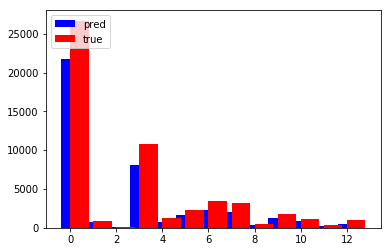

In [36]:
plt.show()

In [10]:
classifier = joblib.load('random.pkl.cmp')

In [ ]:
importance = estimator.feature_importances_
print(importance)